# 1. Contextualização e Entendimento dos Dados (Data Understanding)

 **Objetivo:** Analisar dados históricos de solicitações de crédito para identificar padrões de risco e inadimplência.
 <br><br>
 **Contexto:** O objetivo final é analisar a correlação entre a variável `TARGET` (0 = Pagador, 1 = Inadimplente) e as variáveis auxiliares a fim de identificar padrões e pré-diagnosticar possíveis bons ou maus pagadores para minimizar perdas financeiras.
 <br><br>
 **Metodologia:** Utilizaremos a etapa de *Data Understanding* do **CRISP-DM** para coletar, entender e selecionar os dados mais relevantes para a análise. Nela, faremos um diagnóstico técnico da qualidade dos dados ("Sanity Check") para guiar a etapa de Limpeza (ETL).

 ## 1.1 Importação de Bibliotecas e Configurações

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
# Configuration to see all the columns with Pandas
pd.set_option('display.max_columns', None)

# Chart styles
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (7, 6)

## 1.2 Coleta dos Dados (Data Collection)

Todos os dados utiizados nesse projeto estão disponíveis publicamente na plataforma **Kaggle**.
<br>
Os dados foram obtidos via API do Kaggle e foram armazenados localmente em `data/`. No total, foram importados 10 arquivos `.csv`. Link para repositório do Kaglle: https://www.kaggle.com/datasets/megancrenshaw/home-credit-default-risk 

Inicialmente utilizaremos os dados de `HomeCredit_columns_description.csv` para entender mais sobre os nossos dados e selecionar os que podem ser mais relevantes. Ao final escolheremos os dados utilizados e criaremos algumas hipóteses que serão respondidas no final dos Notebooks

## 1.3 Definição de domínio do Problema e Seleção de Variáveis

Para esta fase do projeto, utilizaremos apenas uma tabela, a `applcation_train.csv` pois somente com ela já podemos obter insights valiosos e ela nos permite a análise de variáveis que podem interferir na inadimplência de clientes. O dataset original application_train contém 122 colunas. Uma análise exploratória em todas as variáveis simultaneamente geraria excesso de ruído e dificultaria a identificação de padrões claros de negócio.

Portanto, utilizaremos uma abordagem baseada em Domínio de Negócio para filtrar o dataset inicialmente. Focaremos nossa atenção nas variáveis que representam os pilares fundamentais da análise de crédito **(os 5 C's)**, reduzindo a dimensionalidade para um conjunto gerenciável e interpretável.  Para nos auxiliar no processo utilizaremos um dicionário de dados disponivel em `data/HomeCredit_columns_description.csv` para selecionar as variáveis que forem mais relevantes.

In [12]:
#Loading the description file
desc_df = pd.read_csv('../data/HomeCredit_columns_description.csv', sep=',')

# Creating a function to filter descriptions for specific tables
selected_table = 'application_{train|test}.csv'
description_list = desc_df[desc_df['Table'] == selected_table].drop(columns=['Table', 'Unnamed: 0']) # Removing unnecessary columns

description_list

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,Target variable (1 - client with payment diffi...,NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


Visando aplicação dos conhecimentos de negócio, selecionamos as colunas pensando nos 5 C's do Crédito: (Character, Capacity, Capital, Collateral, Conditions).

1. **Variáveis Essenciais**
    - `TARGET`: A variável alvo (0 = Pagador, 1 = Dificuldades com o pagamento)
    - `SK_ID_CURR`: Identificador único do empréstimo
    - `NAME_CONTRACT_TYPE`: Tipo de empréstimo (Cashing ou Revolving)

2. **Saúde Financeira do Cliente**
    - `AMT_INCOME_TOTAL`: Renda total
    - `AMT_CREDIT`: Valor do empréstimo pedido
    - `AMT_ANNUITY`: Valor da parcela anual
    - `AMT_GOODS_PRICE`: Preço do Bem (Para financiamento de bens específicos)

3. **Perfil do Cliente**
    - `CODE_GENDER`: Gênero
    - `DAYS_BIRTH`: Idade em dias
    - `NAME_EDUCATION_TYPE`: Maior nível de escolaridade
    - `NAME_FAMILY_STATUS`: Estado Civil
    - `CNT_CHILDREN`: Quantidade de filhos
    - `REGION_RATING_CLIENT`: Avaliação da região onde mora

4. **Estabilidade e Trabalho**
    - `DAYS_EMPLOYED`: Dias empregado
    - `NAME_INCOME_TYPE`: Tipo de renda (Empresário, assalariado, pensionista, etc)
    - `OCCUPATION_TYPE`: Profissão

5. **Ativos e Score Externo**
    - `FLAG_OWN_CAR` e `OWN_CAR_AGE`: Carro próprio e idade do carro
    - `FLAG_OWN_REALTY`: Casa própria
    - `EXT_SOURCE_1`, `2`, e `3`: Scores normalizados de agências externas (Importantes para risco)

In [13]:
#Separating only selected columns
selected_columns = [
    'TARGET', 'SK_ID_CURR',
    'NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 
    'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'CODE_GENDER', 'CNT_CHILDREN', 'DAYS_BIRTH', 
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'DAYS_EMPLOYED', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'OWN_CAR_AGE',
    'REGION_RATING_CLIENT', 
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'
]

df = pd.read_csv('../data/application_train.csv', usecols=selected_columns)

## 1.4 Descrição dos dados (Data Description)

Aqui após a filtragem analisaremos algumas características nos dados selecionado

### 1.4.1 Visão Geral e Tipagem
 Analisaremos a estrutura básica, tipos de dados e volumetria.

In [14]:
# Initial view of the dataset
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,-9461,-637,NaN,Laborers,2,0.083037,0.262949,0.139376
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,-16765,-1188,NaN,Core staff,1,0.311267,0.622246,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,-19046,-225,26.0,Laborers,2,NaN,0.555912,0.729567
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,-19005,-3039,NaN,Laborers,2,NaN,0.650442,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,-19932,-3038,NaN,Core staff,2,NaN,0.322738,NaN


In [15]:
# Dataset size and infos
print(f"Lines: {df.shape[0]}")
print(f"Columns: {df.shape[1]}\n")
df.info()

Lines: 307511
Columns: 22

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SK_ID_CURR            307511 non-null  int64  
 1   TARGET                307511 non-null  int64  
 2   NAME_CONTRACT_TYPE    307511 non-null  object 
 3   CODE_GENDER           307511 non-null  object 
 4   FLAG_OWN_CAR          307511 non-null  object 
 5   FLAG_OWN_REALTY       307511 non-null  object 
 6   CNT_CHILDREN          307511 non-null  int64  
 7   AMT_INCOME_TOTAL      307511 non-null  float64
 8   AMT_CREDIT            307511 non-null  float64
 9   AMT_ANNUITY           307499 non-null  float64
 10  AMT_GOODS_PRICE       307233 non-null  float64
 11  NAME_INCOME_TYPE      307511 non-null  object 
 12  NAME_EDUCATION_TYPE   307511 non-null  object 
 13  NAME_FAMILY_STATUS    307511 non-null  object 
 14  DAYS_BIRTH            307

### 1.4.2 Análise da Variável Alvo (Target Imbalance)

Antes de qualquer coisa, precisamos entender a proporção de inadimplentes no dataset.

Payers (0): 91.93%
Non-payers (1): 8.07%


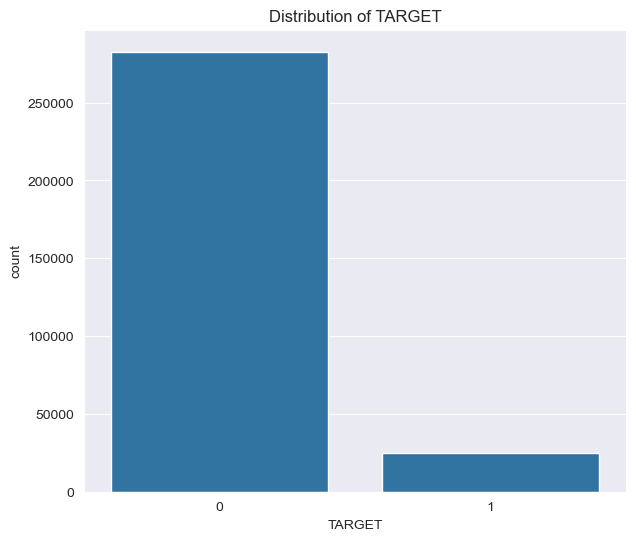

In [110]:
target_counts = df['TARGET'].value_counts(normalize=True) * 100 #Getting percentage of target
print(f'Payers (0): {target_counts[0]:.2f}%')
print(f'Non-payers (1): {target_counts[1]:.2f}%')

plt.title('Distribution of TARGET')
sns.countplot(data=df, x='TARGET');

**Observação:** O dataset é altamente desbalanceado **(~8% de inadimplentes)**. Isso exigirá atenção na validação do modelo.

## 1.5 Verificação de Integridade (Sanity Check)
Nesta etapa, buscamos anomalias técnicas ou de negócio que precisaram ser tratadas no ETL.

In [24]:
#Statistical summary of the dataframe
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,REGION_RATING_CLIENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307511.000000,134133.000000,3.068510e+05,246546.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,-16036.995067,63815.045904,12.061091,2.052463,0.502130,5.143927e-01,0.510853
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,4363.988632,141275.766519,11.944812,0.509034,0.211062,1.910602e-01,0.194844
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-25229.000000,-17912.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,-19682.000000,-2760.000000,5.000000,2.000000,0.334007,3.924574e-01,0.370650
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,-15750.000000,-1213.000000,9.000000,2.000000,0.505998,5.659614e-01,0.535276
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,-12413.000000,-289.000000,15.000000,2.000000,0.675053,6.636171e-01,0.669057
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,-7489.000000,365243.000000,91.000000,3.000000,0.962693,8.549997e-01,0.896010


### 1.5.1 Anomalia em Dias de Emprego
Aqui, podemos identificar uma possível anomalia na coluna `DAYS_EMPLOYED` visto que seu valor máximo foge muito do restante das métricas da coluna. Isso pode ter sido causado por preechimento incorreto ou algum outro motivo.

A documentação sugere que `DAYS_EMPLOYED` deveria ser negativo (dias passados).

In [ ]:
# Counting how many lines have the anomalous value “365243”
anom = df[df['DAYS_EMPLOYED'] == 365243].shape[0]
pct_anom = (anom / df.shape[0]) * 100

print(f'Lines with 365243 days: {anom}')
print(f'Representativeness in the dataset: {pct_anom:.2f}%')

Lines with 365243 data: 55374
Representativeness in the dataset: 18.01%


**Diagnóstico:** Detectamos que 18% da base possui o valor `365243`. Se dividirmos por 365, isso daria 1000 anos. Isso é claramente um erro ou um "código mágico" para aposentados/desempregados.


**Ação para ETL:** Substituir por NaN ou criar uma flag binária.

### 1.5.2 Idade Negativa
 As idades estão em dias negativos. Vamos analisar melhor elas

In [33]:
print(f"Minimum Age (days/years): {df['DAYS_BIRTH'].max()}/{df['DAYS_BIRTH'].max() / 365:.2f}")
print(f"Maximum Age (days/years): {df['DAYS_BIRTH'].min()}/{df['DAYS_BIRTH'].min() / 365:.2f}")



Minimum Age (days/years): -7489/-20.52
Maximum Age (days/years): -25229/-69.12


**Diagnóstico:** Não há nenhum valor que explode. Os dados estão num intervalo aceitável.


**Ação para ETL:** Apenas converter para anos positivos

## 1.6 Qualidade dos Dados (Missing Values)
Vamos quantificar a duplicidade ou ausência de dados para decidir estratégias de preenchimento (imputação).

In [38]:
# Verifying duplicates
print(f'Duplicated lines: {df.duplicated().sum()}')

Duplicated lines: 0


**Diagnóstico:** Sem duplicatas. Portanto, não haverá necessidade de remoção de duplicatas na fase de ETL.

In [40]:
# Creating a null report dataframe
null_report = pd.DataFrame({
    'NULL (Total)': df.isnull().sum(),
    'NULL (%)': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='NULL (%)', ascending=False)

# Showing only columns that have some null values
null_report = null_report[null_report['NULL (Total)'] > 0]
null_report

,NULL (Total),NULL (%)
OWN_CAR_AGE,202929,65.990810
EXT_SOURCE_1,173378,56.381073
OCCUPATION_TYPE,96391,31.345545
EXT_SOURCE_3,60965,19.825307
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902


**Análise de Nulos:**
 - **Críticos (>50%):** `OWN_CAR_AGE` e `EXT_SOURCE_1`. Para as idades dos carros os valores se justificam pois as pessoas podem não ter carro (`FLAG_OWN_CAR`=N). Para Scores externos, a ausência de informação pode ser, por si só, um dado de risco.
 - **Relevantes (~15-50%):** `EXT_SOURCE_3` e `OCCUPATION_TYPE`. Para os cargos de serviço temos a mesma opção que a idade dos carros, os valores se justifcam pela ausência de trabalho ativo, porém podem existir casos de ausência dessa informação (que poderão ser preenchida como `Desconhecido`)
 - **Baixos (<1%):** `AMT_GOODS_PRICE` e `AMT_ANNUITY`.

## 1.7 Análise de Correlações (Relationships)
Vamos verificar como as variáveis numéricas se relacionam. Isso é crucial para identificar **multicolinearidade** (variáveis que dizem a mesma coisa).

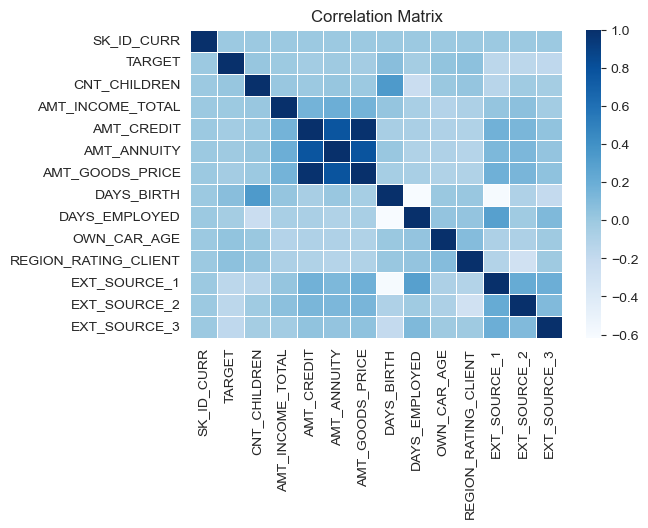

In [58]:
# Numeric columns
numeric_cols = df.dtypes[df.dtypes != 'object'].index.to_list()
correlation_matrix = df[numeric_cols].corr()

plt.title('Correlation Matrix')
sns.heatmap(correlation_matrix, cmap='Blues', linewidths=0.5);

### 1.7.1 Análise Específica: Crédito vs Preço do Bem vs Parcela Anual
Pelo Heatmap podemos ver uma forte correlação entre `AMT_CREDIT`, `AMT_GOODS_PRICE` e `AMT_ANNUITY`. Vamos analisar isso através de um gráfico de dispersão

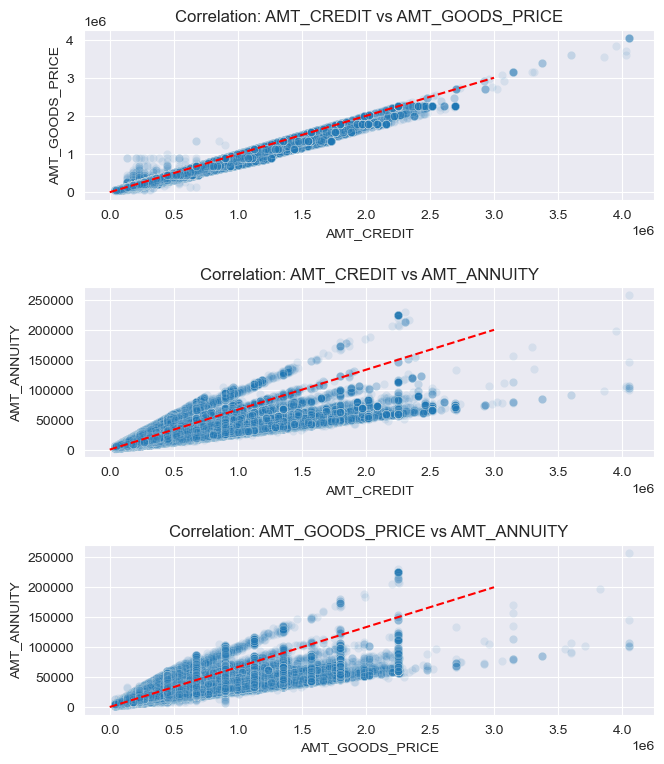

In [104]:
from locale import normalize

scale_1 = 3000000
scale_2 = 200000

def plot_sub_scatter(x, y, s1, s2, ax):
    axes[ax].set_title(f'Correlation: {x} vs {y}')
    axes[ax].plot([0, s1], [0, s2], 'r--') # Reference Line
    sns.scatterplot(data=df, x=x, y=y, alpha=0.1, ax=axes[ax])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,8))

# Chart 01: Credit vs Goods Price
plot_sub_scatter('AMT_CREDIT', 'AMT_GOODS_PRICE', scale_1, scale_1, 0)
# Chart 02: Credit vs Annuity
plot_sub_scatter('AMT_CREDIT', 'AMT_ANNUITY', scale_1, scale_2, 1)
# Chart 03: Goods Price vs Annuity
plot_sub_scatter('AMT_GOODS_PRICE', 'AMT_ANNUITY', scale_1, scale_2, 2)

plt.tight_layout(pad=2)


Embora o gráfico mostre uma correlação quase perfeita entre `AMT_CREDIT`, `AMT_GOODS_PRICE` e `AMT_ANNUITY`, **não removeremos nenhuma das duas** nesta etapa inicial.

**Justificativa:**
1.  **Informação Escondida:** A pequena diferença entre o valor do bem e o valor do crédito representa a **Entrada (Down Payment)** dada pelo cliente. Clientes que dão entrada geralmente apresentam menor risco.
2.  **Relação com a Parcela:** A interação entre `AMT_CREDIT` e `AMT_ANNUITY` nos permite estimar o **Prazo do Empréstimo (Term)**, que não está explícito no dataset.

**Decisão para o ETL:**
Manteremos as três colunas (`CREDIT`, `GOODS_PRICE`, `ANNUITY`) e, no próximo notebook (Feature Engineering), criaremos variáveis derivadas (razões e diferenças) para capturar esses comportamentos de negócio.


## 1.8 Conclusões e Plano de Ação para ETL

 Finalizamos o entendimento dos dados com os seguintes diagnósticos:

 1. **Distribuição:** Temos um desbalanceamento da variável `TARGET`.
 2.  **Integridade:** Identificamos uma anomalia grave em `DAYS_EMPLOYED` (valor 365243) que afeta 18% da base.
 3.  **Formato:** As colunas de datas (`DAYS_...`) estão negativas e precisam de conversão para anos absolutos.
 4.  **Qualidade:** `EXT_SOURCE_1` e `3`, `OCCUPATION_TYPE` e `OWN_CAR_AGE` exigirão estratégias de imputação cuidadosas. `AMT_GOODS_PRICE`, `AMT_CREDIT` e `AMT_ANNUITY` são logicamente correlacionadas.

### 1.8.1 Próxima Etapa: Data Preparation (Notebook 02)

 Baseado neste diagnóstico, o roteiro para o próximo notebook será:

 * **Tratamento de Anomalias:** Substituir `365243` por `NaN` em `DAYS_EMPLOYED` e tronar seu valor (junto com `DAYS_BIRTH`) positivo.
 * **Remoção:** Analisar necessidade de remoção da coluna `OWN_CAR_AGE` devido à grande ausencia de dados.
 * **Imputação (Preenchimento):**
     * Usar a Mediana para `AMT_ANNUITY` (devido a outliers e baixa quantidade de dados faltantes) 
     * Preencher `AMT_GOODS_PRICE` usando `AMT_CREDIT`.
     * Manter `NaN` em `EXT_SOURCE` (para modelos de árvore) ou testar Iterative Imputer.
     * Preencher `OCCUPATION_TYPE` (Desconhecido ou NA para caso de aposentados ou desempregados)
 * **Feature Engineering:**
     * Criar coluna `AGE` (Idade em Anos).
     * Criar `DEBT_TO_INCOME_RATIO` (`AMT_ANNUITY` / `AMT_INCOME_TOTAL`). Mostra o quanto da renda está comprometida
     * Criar `PAYMENT_RATE` (`AMT_ANNUITY` / `AMT_CREDIT`). Mostra o quanto o empréstimo "pesa" anualmente em relação ao total da dívida.
     * Criar `DOWN_PAYMENT`(`AMT_GOODS_PRICE`  - `AMT_CREDIT`)
